In [1]:
%run headers.ipynb
%run dataset.ipynb

In [2]:
(benign_X_train,benign_y_train),(benign_X_test,benign_y_test),(malignant_X_train,malignant_y_train),(malignant_X_test,malignant_y_test),(normal_X_train,normal_y_train),(normal_X_test,normal_y_test) = split_urls(0.8)

In [3]:
print(len(benign_X_train),len(benign_X_test))
print(len(malignant_X_train),len(malignant_X_test))
print(len(normal_X_train),len(normal_X_test))

363 91
168 43
106 27


In [4]:
import albumentations as A

### Visualize images and masks : 

In [5]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

### Read an image and its mask from the disk

In [6]:
image = cv2.imread(benign_X_train[1])
mask = cv2.imread(benign_y_train[1], cv2.IMREAD_GRAYSCALE)

## Original image <a class="anchor" id="original-image"></a>

In [7]:
print(image.shape, mask.shape)

(256, 256, 3) (256, 256)


In [8]:
original_height, original_width = image.shape[:2]
original_height,original_width

(256, 256)

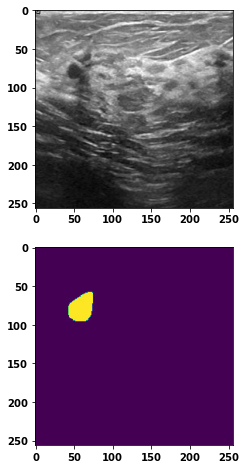

In [9]:
visualize(image, mask)

 # Padding

In [10]:
def visualize_padding(image,mask):
    aug = A.PadIfNeeded(min_height=256, min_width=256, p=1)
    augmented = aug(image=image, mask=mask)
    image_padded = augmented['image']
    mask_padded = augmented['mask']
    print(image_padded.shape, mask_padded.shape)
    visualize(image_padded, mask_padded, original_image=image, original_mask=mask)

In [11]:
def padding(image,mask):
    aug = A.PadIfNeeded(min_height=256, min_width=256, p=1)
    augmented = aug(image=image, mask=mask)
    image_padded = augmented['image']
    mask_padded = augmented['mask']
    return (image_padded,mask_padded)

(256, 256, 3) (256, 256)


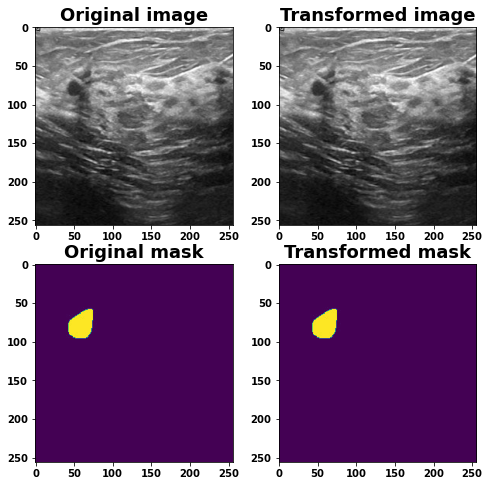

In [12]:
visualize_padding(image,mask)

# CenterCrop and Crop

(256, 256, 3) (256, 256)


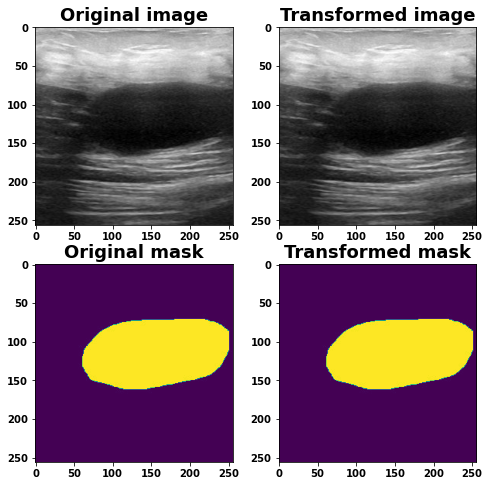

In [13]:
image = cv2.imread(benign_X_train[100])
mask = cv2.imread(benign_y_train[100], cv2.IMREAD_GRAYSCALE)

aug = A.PadIfNeeded(min_height=256, min_width=256, p=1)
augmented = aug(image=image, mask=mask)
image_padded = augmented['image']
mask_padded = augmented['mask']

aug = A.CenterCrop(p=1, height=original_height, width=original_width)

augmented = aug(image=image_padded, mask=mask_padded)

image_center_cropped = augmented['image']
mask_center_cropped = augmented['mask']

print(image_center_cropped.shape, mask_center_cropped.shape)

assert (image - image_center_cropped).sum() == 0
assert (mask - mask_center_cropped).sum() == 0

visualize(image_padded, mask_padded, original_image=image_center_cropped, original_mask=mask_center_cropped)

(256, 256, 3) (256, 256)


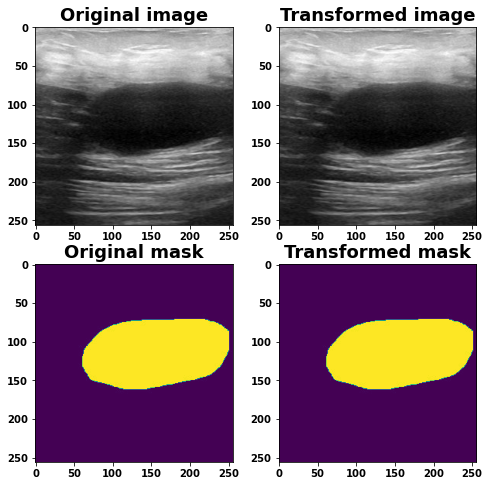

In [14]:
x_min = (256 - original_width) // 2
y_min = (256 - original_height) // 2

x_max = x_min + original_width
y_max = y_min + original_height

aug = A.Crop(x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, p=1)

augmented = aug(image=image_padded, mask=mask_padded)

image_cropped = augmented['image']
mask_cropped = augmented['mask']

print(image_cropped.shape, mask_cropped.shape)

assert (image - image_cropped).sum() == 0
assert (mask - mask_cropped).sum() == 0

visualize(image_cropped, mask_cropped, original_image=image_padded, original_mask=mask_padded)

# Non destructive transformations.

 ## HorizontalFlip

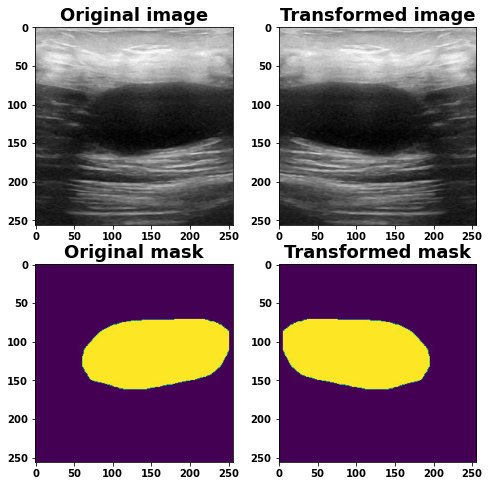

In [15]:
aug = A.HorizontalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)

## VerticalFlip

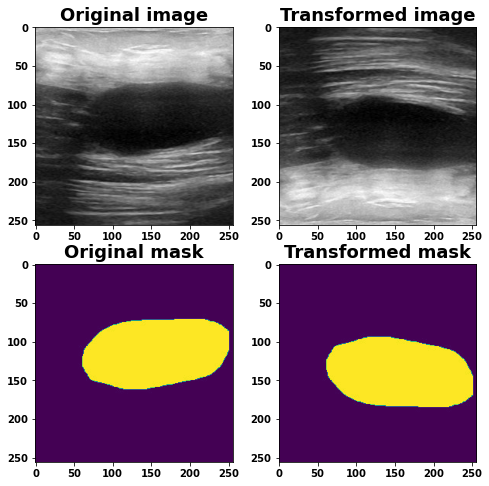

In [16]:
aug = A.VerticalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_v_flipped = augmented['image']
mask_v_flipped = augmented['mask']

visualize(image_v_flipped, mask_v_flipped, original_image=image, original_mask=mask)

## RandomRotate90 (Randomly rotates by 0, 90, 180, 270 degrees)

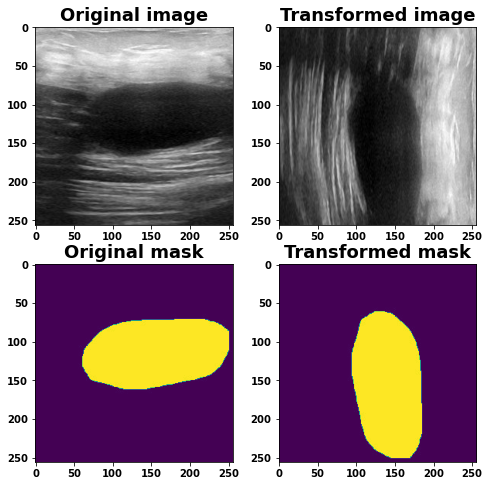

In [17]:
aug = A.RandomRotate90(p=1)

augmented = aug(image=image, mask=mask)

image_rot90 = augmented['image']
mask_rot90 = augmented['mask']

visualize(image_rot90, mask_rot90, original_image=image, original_mask=mask)

 ## Transpose (switch X and Y axis) 

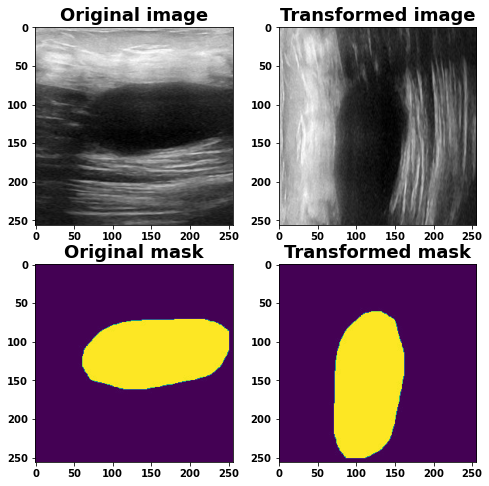

In [18]:
aug = A.Transpose(p=1)

augmented = aug(image=image, mask=mask)

image_transposed = augmented['image']
mask_transposed = augmented['mask']

visualize(image_transposed, mask_transposed, original_image=image, original_mask=mask)

# Non-rigid transformations: ElasticTransform, GridDistortion, OpticalDistortion

### ElasticTransform

In [19]:
malignant_X_train[30]

'D:/tumor/resized/malignant/malignant (94) resized.jpg'

In [20]:
malignant_y_train[30]

'D:/tumor/resized/malignant/malignant (94)_mask resized_greyscale.jpg'

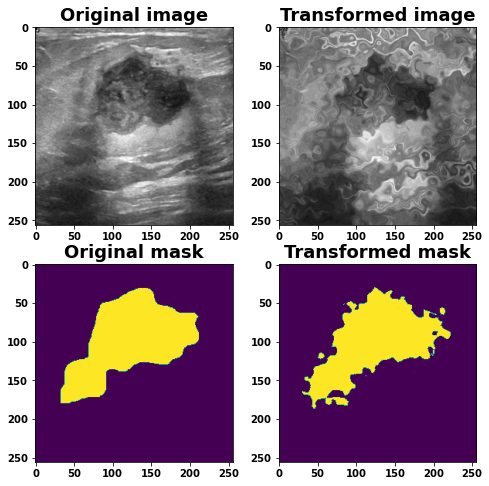

In [21]:
image = cv2.imread(malignant_X_train[30])
mask = cv2.imread(malignant_y_train[30], cv2.IMREAD_GRAYSCALE)
aug = A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.03, alpha_affine=120 * 0.03)

augmented = aug(image=image, mask=mask)

image_elastic = augmented['image']
mask_elastic = augmented['mask']

visualize(image_elastic, mask_elastic, original_image=image, original_mask=mask)

### GridDistortion

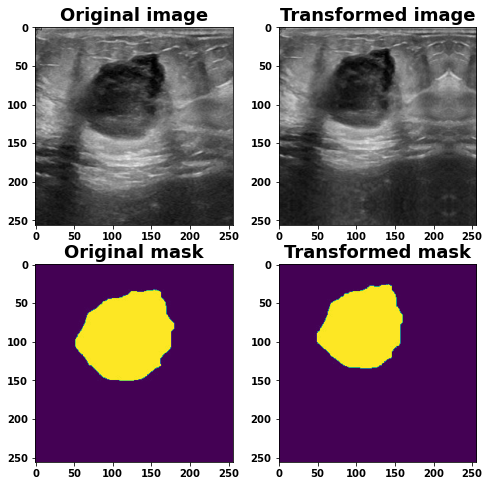

In [22]:
image = cv2.imread(malignant_X_train[120])
mask = cv2.imread(malignant_y_train[120], cv2.IMREAD_GRAYSCALE)
aug = A.GridDistortion(p=1)

augmented = aug(image=image, mask=mask)

image_grid = augmented['image']
mask_grid = augmented['mask']

visualize(image_grid, mask_grid, original_image=image, original_mask=mask)

### OpticalDistortion

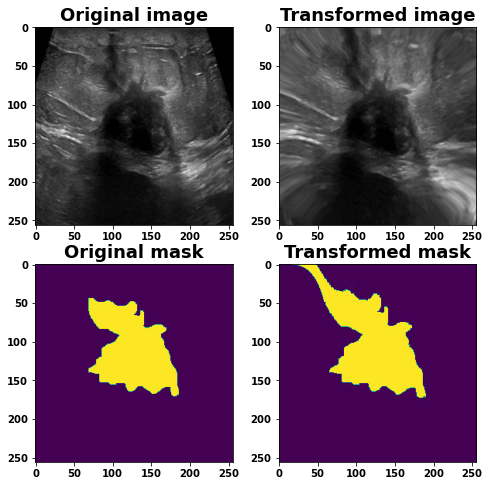

In [23]:
image = cv2.imread(malignant_X_train[110])
mask = cv2.imread(malignant_y_train[110], cv2.IMREAD_GRAYSCALE)

aug = A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)

augmented = aug(image=image, mask=mask)

image_optical = augmented['image']
mask_optical = augmented['mask']

visualize(image_optical, mask_optical, original_image=image, original_mask=mask)

# RandomSizedCrop

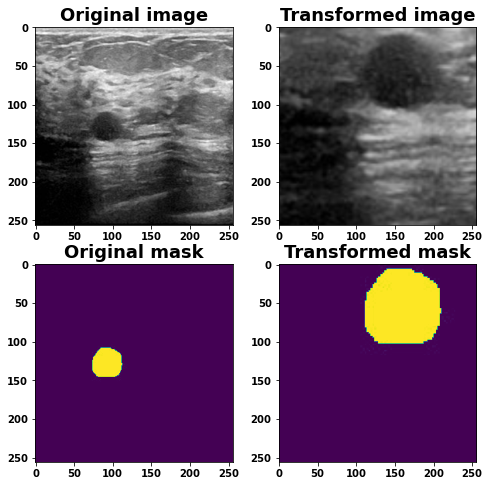

In [139]:
image = cv2.imread(benign_X_train[121])
mask = cv2.imread(benign_y_train[121], cv2.IMREAD_GRAYSCALE)

aug = A.RandomSizedCrop(min_max_height=(100, 101), height=original_height, width=original_width, p=1)

augmented = aug(image=image, mask=mask)

image_scaled = augmented['image']
mask_scaled = augmented['mask']

visualize(image_scaled, mask_scaled, original_image=image, original_mask=mask)

# Light non-destructive augmentations

In [184]:
def light_augmentation(image,mask):
    aug = A.Compose([
        A.VerticalFlip(p=0.5),              
        A.RandomRotate90(p=0.5)]
    )

    augmented = aug(image=image, mask=mask)

    image_light = augmented['image']
    mask_light = augmented['mask']
    
    return (image_light,mask_light)

## Medium augmentations (Non rigid transformations and RandomSizedCrop)

In [185]:
def medium_augmentation(image,mask):
    image = cv2.imread(benign_X_train[201])
    mask = cv2.imread(benign_y_train[201], cv2.IMREAD_GRAYSCALE)

    aug = A.Compose([
        A.RandomSizedCrop(min_max_height=(100, 101), height=original_height, width=original_width, p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.8)])

    augmented = aug(image=image, mask=mask)

    image_medium = augmented['image']
    mask_medium = augmented['mask']
    
    return (image_medium,mask_medium)

# Non-spatial transformations.
#### Many non-spatial transformations like CLAHE, RandomBrightness, RandomContrast, RandomGamma can be also added. They will be applied only to the image and not the mask.

In [179]:
def heavy_augmentation(image,mask):
    aug = A.Compose([
        A.RandomSizedCrop(min_max_height=(100, 101), height=original_height, width=original_width, p=0.5),
        A.VerticalFlip(p=0.5),              
        A.RandomRotate90(p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
            ], p=0.8),
        A.CLAHE(p=0.8),
        A.RandomBrightnessContrast(p=0.8),    
        A.RandomGamma(p=0.8)])

    augmented = aug(image=image, mask=mask)

    image_heavy = augmented['image']
    mask_heavy = augmented['mask']
    
    return (image_heavy,mask_heavy)

In [187]:
print(len(benign_X_train),len(benign_X_test))
print(len(malignant_X_train),len(malignant_X_test))
print(len(normal_X_train),len(normal_X_test))

363 91
168 43
106 27
